# Agent

In [ ]:
!pip install -U langchain_anthropic

In [3]:
import getpass
import os

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("ANTHROPIC_API_KEY")

In [4]:
# Helper
def visualize_graph(graph):
    from IPython.display import Image, display
    try:
        display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
    except Exception:
        # This requires some extra dependencies and is optional
        pass

## Part 1: 기본 챗봇

In [5]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

우리는 `State`를 단일 키 `messages`를 가진 `TypedDict`로 정의했습니다. `messages` 키는 [`add_messages`](https://langchain-ai.github.io/langgraph/reference/graphs/?h=add+messages#add_messages) 함수로 주석이 달려 있으며, 이는 LangGraph에게 새로운 메시지를 기존 리스트에 덮어쓰지 않고 추가하도록 지시합니다.

따라서 이제 우리의 그래프는 두 가지를 알고 있습니다:

1. 우리가 정의하는 모든 `node`는 현재의 `State`를 입력으로 받고, 그 상태를 업데이트하는 값을 반환합니다.
2. `messages`는 현재 리스트에 직접 덮어쓰는 것이 아니라 추가됩니다. 이는 `Annotated` 문법의 사전 정의된 [`add_messages`](https://langchain-ai.github.io/langgraph/reference/graphs/?h=add+messages#add_messages) 함수를 통해 전달됩니다.

다음으로, "`chatbot`" 노드를 추가합니다.


In [6]:
from langchain_anthropic import ChatAnthropic

llm = ChatAnthropic(model="claude-3-haiku-20240307")


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)


`chatbot` 노드 함수가 현재 `State`를 입력으로 받아 업데이트된 `messages` 리스트를 반환합니다.

우리의 `State`에 있는 `add_messages` 함수는 LLM의 응답 메시지를 현재 상태에 이미 있는 메시지에 추가할 것입니다.

다음으로, `entry` 지점을 추가합니다. 이는 우리가 그래프를 실행할 때마다 **어디서 작업을 시작해야 하는지**를 그래프에 알려줍니다.


In [7]:
graph_builder.set_entry_point("chatbot") # == graph_builder.add_edge(START, "chatbot")

마찬가지로, 종료가 되는`finish` 노드를 지정합니다.

In [8]:
graph_builder.set_finish_point("chatbot")  # == graph_builder.add_edge("chatbot", END)

In [9]:
graph = graph_builder.compile()

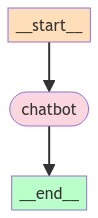

In [10]:
visualize_graph(graph)

대화 시작

In [11]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("대화 종료.")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

User:  안녕


Assistant: 안녕하세요! 오늘 하루 좋은 하루 보내셨나요? 무엇이든 도와드릴 일이 있다면 말씀해주세요.


User:  만나서 반가워


Assistant: 네, 저도 만나서 정말 반가워요! 오늘 날씨가 참 좋아서 기분이 좋습니다. 오늘 하루 어떤 계획들이 있으신지 궁금해요. 혹시 좋은 이야기들도 있나요? 제가 들어보고 싶은데요.


User:  q


대화 종료.


## Part 2: Tool을 사용하는 Chatbot => Agent 만들기

우리 챗봇이 “기억에서” 대답할 수 없는 질문을 처리하기 위해, 웹 검색 도구를 통합할 것입니다. 우리의 챗봇은 검색 도구를 사용하여 관련 정보를 찾아 더 나은 응답을 제공할 수 있습니다.

#### Requirements

Tavily 패키지를 설치하고 API 키를 설정해야합니다.

먼저, [Tavily 검색 엔진](https://python.langchain.com/v0.2/docs/integrations/tools/tavily_search/)을 사용하기 위한 요구 사항을 설치하고, [TAVILY_API_KEY](https://tavily.com/)를 설정하세요.


In [ ]:
!pip install -U tavily-python

In [12]:
_set_env("TAVILY_API_KEY")

In [13]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("LangGraph에서 ‘노드’란 무엇인가요?")

[{'url': 'https://langchain-ai.github.io/langgraph/concepts/',
  'content': "LangGraph introduces two key ideas to state management: state schemas and reducers. The state schema defines the type of the object that is given to each of the graph's Node. Reducers define how to apply Node outputs to the current State. For example, you might use a reducer to merge a new dialogue response into a conversation history, or ..."},
 {'url': 'https://langchain-ai.github.io/langgraph/',
  'content': 'With LangGraph, you can build complex, stateful agents without getting bogged down in manual state and interrupt management. Just define your nodes, edges, and state schema - and let the graph take care of the rest. Tutorials¶ Consult the Tutorials to learn more about building with LangGraph, including advanced use cases. How-To Guides¶'}]

결과는 우리의 챗봇이 질문에 답하기 위해 사용할 수 있는 페이지 요약입니다.

다음으로, 그래프 정의를 시작하겠습니다. 다음 내용은 **1부와 동일**하지만, LLM에 `bind_tools`를 추가했습니다. 이를 통해 LLM은 검색 엔진을 사용하려고 할 때 올바른 JSON 형식을 알 수 있습니다.

In [14]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


llm = ChatAnthropic(model="claude-3-haiku-20240307")
# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

다음으로, 호출된 도구를 실제로 실행하는 함수를 만들어야 합니다. 이를 위해 새 노드에 도구를 추가하겠습니다.

아래에, 상태에서 가장 최근의 메시지를 확인하고, 메시지에 `tool_calls`가 포함되어 있으면 도구를 호출하는 `BasicToolNode`를 구현하세요. 이 노드는 Anthropic, OpenAI, Google Gemini 등 여러 LLM 제공자에서 사용할 수 있는 LLM의 `tool_calling` 지원에 의존합니다.

나중에 LangGraph의 사전 구축된 [ToolNode](https://langchain-ai.github.io/langgraph/reference/prebuilt/#toolnode)로 대체하여 사용 될 수 있습니다.

In [15]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

도구 노드를 추가한 후, 이제 `conditional_edges`를 정의할 수 있습니다.

아래에서는 챗봇의 출력에서 `tool_calls`를 확인하는 `route_tools`라는 라우터 함수를 정의하세요. 이 함수를 그래프에 제공하려면 `add_conditional_edges`를 호출하여 `chatbot` 노드가 완료될 때마다 이 함수를 확인하여 다음으로 어디로 이동할지 결정하도록 그래프에 알려주세요.

조건부는 `tool_calls`가 있으면 `tools`로, 없으면 "`__end__`"로 라우팅됩니다.

나중에 이를 더 간결하게 하기 위해 사전 구축된 [tools_condition](https://langchain-ai.github.io/langgraph/reference/prebuilt/#tools_condition)으로 대체할 예정이지만, 처음에는 직접 구현하여 더 명확하게 이해할 수 있습니다.


In [16]:
from typing import Literal


def route_tools(
    state: State,
) -> Literal["tools", "__end__"]:
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "__end__"


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "__end__" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    {"tools": "tools", "__end__": "__end__"},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()

조건부 에지는 단일 노드에서 시작됩니다. 이는 그래프에 "`chatbot`" 노드가 실행될 때마다, 도구를 호출하면 'tools'로 가고, 직접 응답하면 루프를 종료하도록 지시합니다.

사전 구축된 `tools_condition`과 마찬가지로, 우리 함수는 도구 호출이 없을 경우 "`__end__`" 문자열을 반환합니다. 그래프가 `__end__`로 전환되면 더 이상 완료해야 할 작업이 없으므로 실행이 중지됩니다. 조건이 `__end__`를 반환할 수 있기 때문에, 이번에는 명시적으로 `finish_point`를 설정할 필요가 없습니다. 우리의 그래프에는 이미 종료할 방법이 있습니다.

이제 우리가 구축한 그래프를 시각화해 봅시다. 다음 함수는 이 튜토리얼에서는 중요하지 않은 추가 종속성이 필요합니다.


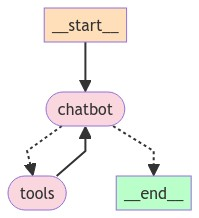

In [17]:
visualize_graph(graph)

Now we can ask the bot questions outside its training data.

In [18]:
from langchain_core.messages import BaseMessage

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("대화 종료!")
        break
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                print("Assistant:", value["messages"][-1].content)

User:  미국 대선 언제야


Assistant: [{'id': 'toolu_015UiDo3NKESgU9fKhXB2jDP', 'input': {'query': '미국 대선 일정'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Assistant: [{"url": "https://namu.wiki/w/2024\ub144 \ubbf8\uad6d \ub300\ud1b5\ub839 \uc120\uac70", "content": "\uac1c\uc694 [\ud3b8\uc9d1] 2024\ub144 11\uc6d4 5\uc77c \uc5d0 \uc2dc\ud589 \uc608\uc815\uc778 \ubbf8\uad6d \ub300\ud1b5\ub839 \uc120\uac70. \ubbf8\uad6d \uc758 60\ubc88\uc9f8 \ub300\ud1b5\ub839 \uc120\uac70\uc774\uace0 \uc81c47\ub300 \ub300\ud1b5\ub839 \uc744 \uc120\ucd9c\ud558\uac70\ub098 46\ub300 \ub300\ud1b5\ub839 \uc870 \ubc14\uc774\ub4e0 \uc774 \uc7ac\uc120 \uc5d0 \ub3c4\uc804\ud558\ub294 \uc120\uac70\ub2e4. \uc0c1\ub300\ub294 \uc9c1\uc804 45\ub300 \ub300\ud1b5\ub839 \ub3c4\ub110\ub4dc \ud2b8\ub7fc\ud504 \ub85c, 1912\ub144 \ubbf8\uad6d \ub300\ud1b5\ub839 \uc120\uac70 \uc774\ud6c4 112\ub144\ub9cc\uc5d0 \uc804 ..."}, {"url": "https://www.bbc.com/korean/international-65186660", "content": "\ub354 \ubcf4\uae30\n\ubbf8 \uc911\uac04\uc

User:  q


대화 종료!


User:  q


Goodbye!


## All in one!

In [ ]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-haiku-20240307")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()

## Part 3: 메모리 추가하기

우리의 챗봇은 이제 도구를 사용하여 사용자 질문에 답할 수 있지만, 이전 상호작용의 맥락을 기억하지 못합니다. 이는 일관성 있는 여러 턴의 대화를 하는 데 한계를 가져옵니다.

LangGraph는 **지속적인 체크포인트 저장**을 통해 이 문제를 해결합니다. 그래프를 컴파일할 때 `checkpointer`를 제공하고, 그래프를 호출할 때 `thread_id`를 제공하면, LangGraph는 각 단계 후 상태를 자동으로 저장합니다. 동일한 `thread_id`를 사용하여 그래프를 다시 호출하면, 그래프는 저장된 상태를 로드하여 챗봇이 이전 상태에서 계속 작업할 수 있게 합니다.

나중에 **체크포인트 저장**이 단순한 대화 메모리보다 _훨씬_ 더 강력하다는 것을 알게 될 것입니다. 이는 언제든지 복잡한 상태를 저장하고 복구하여 오류 복구, 인간-상호작용 워크플로우, 시간 여행 상호작용 등을 가능하게 합니다. 하지만 너무 앞서 나가기 전에, 체크포인트를 추가하여 여러 턴의 대화를 가능하게 해 봅시다.

시작하려면, `SqliteSaver` 체크포인터를 생성하세요.

In [19]:
from langgraph.checkpoint.sqlite import SqliteSaver

# In memory:
memory = SqliteSaver.from_conn_string(":memory:")

# To disk:
# memory = SqliteSaver.from_conn_string("checkpoints.sqlite")

우리는 Sqlite DB 경로로 `:memory`를 지정했습니다. 이는 튜토리얼을 위해 편리한데, 모든 것을 메모리에 저장합니다. 실제 응용 프로그램에서는 이를 변경하여 자체 DB에 연결하거나 다른 체크포인터 클래스를 사용하는 것이 좋습니다.

다음으로 그래프를 정의하세요. 이미 `BasicToolNode`를 직접 구축했으므로, LangGraph의 사전 구축된 `ToolNode`와 `tools_condition`으로 이를 교체할 것입니다. 이들은 병렬 API 실행과 같은 유용한 기능을 제공합니다. 그 외의 내용은 모두 2부에서 복사해온 것입니다.

In [21]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-haiku-20240307")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")

Finally, compile the graph with the provided checkpointer.

In [22]:
graph = graph_builder.compile(checkpointer=memory)

Notice the connectivity of the graph hasn't changed since Part 2. All we are doing is checkpointing the `State` as the graph works through each node.

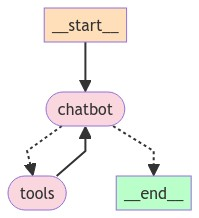

In [23]:
visualize_graph(graph)

In [24]:
config = {"configurable": {"thread_id": "1"}}

In [25]:
user_input = "안녕 나는 Liam이야."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

안녕 나는 Liam이야.
================================== Ai Message ==================================

반갑습니다 Liam! 저도 반가워요. 오늘 기분이 어떠신가요? 무엇을 하고 싶으신가요? 제가 도움이 되는 방법이 있다면 알려주세요.


**참고:** 설정(config)은 그래프를 호출할 때 **두 번째 위치 인자**로 제공되었습니다. 중요한 점은 그래프 입력(`{'messages': []}`) 내에 포함되지 않는다는 것입니다.

이름을 기억하는지 확인해봅시다.


In [26]:
user_input = "내 이름 기억해?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

내 이름 기억해?
================================== Ai Message ==================================

네, 당신의 이름이 Liam이라는 것을 잘 기억하고 있습니다. 처음 대화할 때 Liam이라고 소개해주셨죠. 저는 사용자분의 이름을 빠르게 기억하고 있으며, 이후 대화에서도 계속해서 사용자 이름을 활용할 것입니다. 이렇게 개인적인 대화를 나누게 되어 기쁩니다.


**참고**: 메모리 관리를 위해 외부 리스트를 사용하지 않는다는 점에 유의하세요. 이는 모두 체크포인터에 의해 처리됩니다.

In [27]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [("user", user_input)]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

내 이름 기억해?
================================== Ai Message ==================================

[{'id': 'toolu_01N3aSPfj8jGx8jGwh3kQPJS', 'input': {'query': '내 이름 기억해'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_01N3aSPfj8jGx8jGwh3kQPJS)
 Call ID: toolu_01N3aSPfj8jGx8jGwh3kQPJS
  Args:
    query: 내 이름 기억해
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://hinative.com/questions/16690237", "content": "\ub0b4 \uc774\ub984\uc744 \uae30\uc5b5\ud574 (nae i-reum-eur gi-eog-hae ) Definition of \ub0b4 \uc774\ub984\uc744 \uae30\uc5b5\ud574 Remember my name. Sign up; Sign in; Question Updated on 28 Jun 2020 jinah_07. 28 Jun 2020. English (US) Japanese Korean Simplified Chinese (China) Question about Korean. What does ..."}, {"url": "https://m.blog.naver.com/hasajon/223080615

**공지**: 앞선 강의에서 다뤘든 대화의 내용은 thread 별로 분리되어있습니다.

지금까지 우리는 두 개의 다른 스레드에서 몇 가지 체크포인트를 만들었습니다. 그렇다면 체크포인트에 무엇이 들어갈까요? 주어진 설정(config)에 대한 그래프의 `state`를 언제든지 검사하려면, `get_state(config)`를 호출하세요.

In [29]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='안녕 나는 Liam이야.', id='262865f3-01b8-45af-ad67-c48baef60a56'), AIMessage(content='반갑습니다 Liam! 저도 반가워요. 오늘 기분이 어떠신가요? 무엇을 하고 싶으신가요? 제가 도움이 되는 방법이 있다면 알려주세요.', response_metadata={'id': 'msg_018yywsXBpcJSb5GsioJSKtn', 'model': 'claude-3-haiku-20240307', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'input_tokens': 381, 'output_tokens': 81}}, id='run-2d505fd2-9201-4b3d-9e37-15e4e47cfa09-0', usage_metadata={'input_tokens': 381, 'output_tokens': 81, 'total_tokens': 462}), HumanMessage(content='내 이름 기억해?', id='4cf69daf-e79a-4c2f-8adc-f50122477e06'), AIMessage(content='네, 당신의 이름이 Liam이라는 것을 잘 기억하고 있습니다. 처음 대화할 때 Liam이라고 소개해주셨죠. 저는 사용자분의 이름을 빠르게 기억하고 있으며, 이후 대화에서도 계속해서 사용자 이름을 활용할 것입니다. 이렇게 개인적인 대화를 나누게 되어 기쁩니다.', response_metadata={'id': 'msg_01EwuzNX457iGZB1Zp4Q7Cco', 'model': 'claude-3-haiku-20240307', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'input_tokens': 475, 'output_tokens': 153}}, id='run-1b9cbd49-5e

In [30]:
snapshot.next  # (그래프가 이번 턴에 종료되었기 때문에, next는 비어 있습니다. 그래프 호출 중에 상태를 가져오면, next는 다음에 실행될 노드를 나타냅니다)

()

위의 스냅샷에는 현재 상태 값, 해당 구성(config), 그리고 처리할 `next` 노드가 포함되어 있습니다. 우리의 경우, 그래프는 `__end__` 상태에 도달했기 때문에 `next`는 비어 있습니다.

## All-in-one Again!

In [ ]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-haiku-20240307")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile(checkpointer=memory)